# Imports

In [1]:
import pandas as pd
import sqlite3
import seaborn as sns
sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import random
random.seed(2000) #for reproducibility

C:\Users\Kirubha\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Kirubha\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\Kirubha\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


# Reading DF

In [2]:
df = pd.read_csv("C:\\Users\\Kirubha\\Desktop\\ICU.csv")
del df['Unnamed: 0']
df.head(5)

,ID,Survive,Age,AgeGroup,Sex,Infection,SysBP,Pulse,Emergency
0,4,0,87,3,1,1,80,96,1
1,8,1,27,1,1,1,142,88,1
2,12,1,59,2,0,0,112,80,1
3,14,1,77,3,0,0,100,70,0
4,27,0,76,3,1,1,128,90,1


In [3]:
df.isna().any() #no null values

ID           False
Survive      False
Age          False
AgeGroup     False
Sex          False
Infection    False
SysBP        False
Pulse        False
Emergency    False
dtype: bool

In [4]:
df.duplicated().any() #no duplicates

False

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   ID         200 non-null    int64
 1   Survive    200 non-null    int64
 2   Age        200 non-null    int64
 3   AgeGroup   200 non-null    int64
 4   Sex        200 non-null    int64
 5   Infection  200 non-null    int64
 6   SysBP      200 non-null    int64
 7   Pulse      200 non-null    int64
 8   Emergency  200 non-null    int64
dtypes: int64(9)
memory usage: 14.2 KB


In [6]:
#to find out what each categories age ranges are
agegrp1 = sorted(df[df['AgeGroup']==1]['Age'].values) #16-49 : Below 50
print(min(agegrp1),max(agegrp1))
agegrp2 = sorted(df[df['AgeGroup']==2]['Age'].values) #50-69 : 50-69
print(min(agegrp2),max(agegrp2))
agegrp3 = sorted(df[df['AgeGroup']==3]['Age'].values) #70-92 : 70 and above
print(min(agegrp3),max(agegrp3))

16 49
50 69
70 92


In [7]:
numDF = df[['Age','SysBP','Pulse']] #no abnormal values (e.g. negative values)
numDF.describe() 

,Age,SysBP,Pulse
count,200.000000,200.000000,200.00000
mean,57.545000,132.280000,98.92500
std,20.054648,32.952099,26.82962
min,16.000000,36.000000,39.00000
25%,46.750000,110.000000,80.00000
50%,63.000000,130.000000,96.00000
75%,72.000000,150.000000,118.25000
max,92.000000,256.000000,192.00000


In [8]:
for col in df.columns:
    print(col,':',df[col].duplicated().any()) #All except ID has duplicates --> ID is unique key

ID : False
Survive : True
Age : True
AgeGroup : True
Sex : True
Infection : True
SysBP : True
Pulse : True
Emergency : True


# SQLite Connection

In [9]:
con = sqlite3.connect('icu.db')
cursor = con.cursor()

In [10]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
db_tables= [x[0] for x in cursor.fetchall()] 
print(db_tables) #no tables currently

[]


## Create Tables

In [11]:
sql_commands = [    
    """
    CREATE TABLE if not Exists age_groups (
    age_group_id INTEGER PRIMARY KEY,
    age_group_name TEXT
    )
    """,
    
    """
    CREATE TABLE if not Exists sexes (
    sex_id INTEGER PRIMARY KEY,
    sex_name TEXT
    )
    """,
    
    """ 
    CREATE TABLE if not Exists patients (
    patient_id INTEGER PRIMARY KEY,
    age INTEGER,
    age_group_id INTEGER,
    sex_id INTEGER,
    FOREIGN KEY (age_group_id) REFERENCES age_groups (age_group_id),
    FOREIGN KEY (sex_id) REFERENCES sexes (sex_id)
    )
    """,
    
    """
    CREATE TABLE if not Exists patient_visits (
    patient_id INTEGER,
    survive BOOLEAN,
    infection BOOLEAN,
    sys_bp INTEGER,
    pulse INTEGER,
    emergency BOOLEAN,
    FOREIGN KEY (patient_id) REFERENCES patients (patient_id)
    )
    """
    
    
]

for command in sql_commands:
    cursor.execute(command)


In [12]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
db_tables= [x[0] for x in cursor.fetchall()] 
print(db_tables) # 4 tables added

['age_groups', 'sexes', 'patients', 'patient_visits']


## Insert Values

In [13]:
update_tables = [
"""
INSERT INTO age_groups (age_group_id, age_group_name)
VALUES (1,'Below 50'), (2,'50-69'), (3,'70 and above')
""",
"""
INSERT INTO sexes (sex_id, sex_name)
VALUES (0,'Female'),(1,'Male')
"""
]


for command in update_tables:
    cursor.execute(command)

In [14]:
patient_values = ''
for row in range(len(df)):
    pid = df.loc[row,'ID']
    age = df.loc[row,'Age']
    agegrp = df.loc[row,'AgeGroup']
    sex = df.loc[row,'Sex']
    val = '('+str(pid)+','+str(age)+','+str(agegrp)+','+str(sex)+')'
    if row!=(len(df)-1):
        val+=', '
    patient_values += val

patient_command = """
INSERT INTO patients (patient_id,age,age_group_id,sex_id)
VALUES """ + patient_values

cursor.execute(patient_command)

In [15]:
visit_values = ''
for row in range(len(df)):
    pid = df.loc[row,'ID']
    survive = df.loc[row,'Survive']
    inf = df.loc[row,'Infection']
    sysbp = df.loc[row,'SysBP']
    pulse = df.loc[row,'Pulse']
    ems = df.loc[row,'Emergency']
    val = '('+str(pid)+','+str(survive)+','+str(inf)+','+str(sysbp)+','+str(pulse)+','+str(ems)+')'
    if row!=(len(df)-1):
        val+=', '
    visit_values += val

patient_visit_command = """
INSERT INTO patient_visits (patient_id,survive,infection,sys_bp,pulse,emergency)
VALUES """ + visit_values

cursor.execute(patient_visit_command)

In [16]:
data=cursor.execute('SELECT * FROM ' +str(db_tables[3])) #just to check
data_descr=[x[0] for x in data.description]
print(data_descr)

['patient_id', 'survive', 'infection', 'sys_bp', 'pulse', 'emergency']


In [17]:
con.commit() #to save
con.close()

# Visualizations

In [18]:
conn = sqlite3.connect('icu.db')

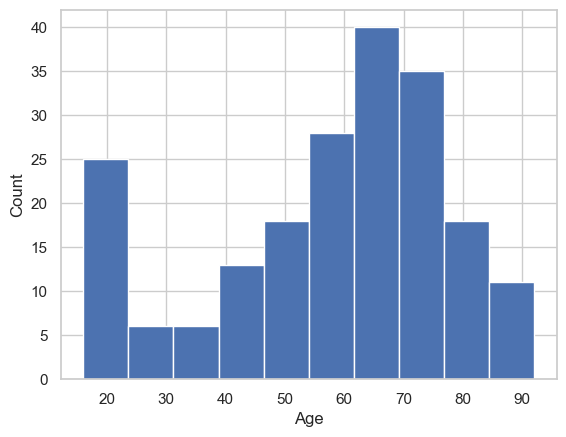

In [19]:
# Histogram for distribution of ages 
age_df = pd.read_sql_query("SELECT age FROM patients", conn)
plt.hist(age_df)
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

Most of them are in their 60s and 70s

<AxesSubplot:>

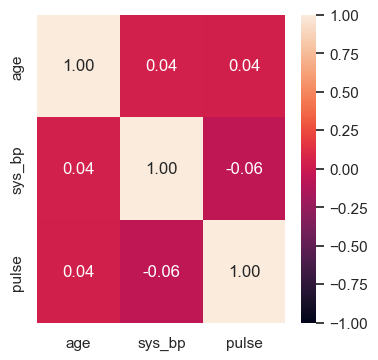

In [20]:
# Heatmap for relationship between numeric attributes
patient_data = pd.read_sql_query("SELECT age,sys_bp,pulse FROM patients p INNER JOIN patient_visits pv ON p.patient_id = pv.patient_id", conn)
f, axes = plt.subplots(1, 1, figsize=(4,4))
sns.heatmap(patient_data[['age','sys_bp','pulse']].corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f") 

Weak relationship between these variables since the coefficients are all close to 0

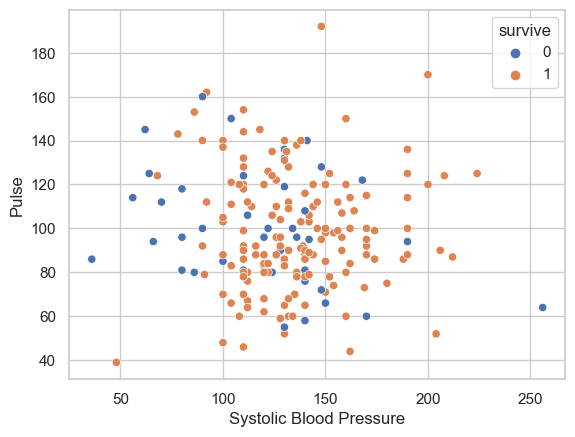

In [21]:
#Scatter plot for relationship between Pulse and Sys BP based on survival
patient_data = pd.read_sql_query("SELECT sys_bp,pulse,survive FROM patients p INNER JOIN patient_visits pv ON p.patient_id = pv.patient_id", conn)
sns.scatterplot(x='sys_bp', y='pulse', hue='survive', data=patient_data)
plt.xlabel('Systolic Blood Pressure')
plt.ylabel('Pulse')
plt.show()

Supports the evidence from heatmap that the relationship is weak since there is no clear trend observable

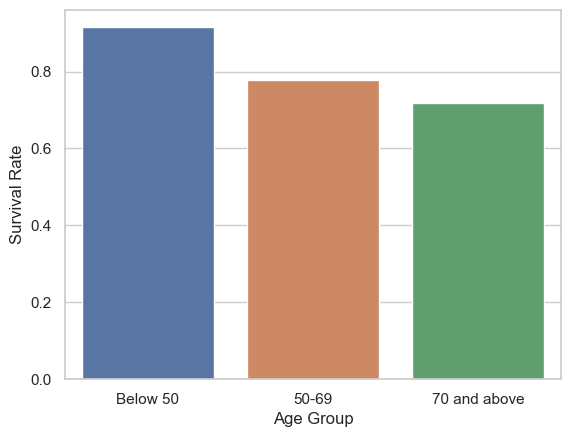

In [22]:
#Barplot for survival rate by age group
patient_data = pd.read_sql_query("""SELECT p.age_group_id, ag.age_group_name,survive FROM patients p 
JOIN patient_visits pv 
ON p.patient_id = pv.patient_id  
JOIN age_groups ag
ON ag.age_group_id = p.age_group_id """, conn)
survival_rate_by_age = patient_data.groupby(['age_group_name', 'survive']).size().unstack().reset_index()
survival_rate_by_age['Survival Rate'] = survival_rate_by_age[True] / (survival_rate_by_age[True] + survival_rate_by_age[False])
survival_rate_by_age = survival_rate_by_age.sort_values(by='Survival Rate',ascending=False)
sns.barplot(x='age_group_name', y='Survival Rate', data=survival_rate_by_age)
plt.xlabel('Age Group')
plt.ylabel('Survival Rate')
plt.show()

The highest survival rate is for those below 50. As age gets larger, the survival rate decreases as observed by the decreasing trend in the rates

<AxesSubplot:xlabel='age_group_name', ylabel='sys_bp'>

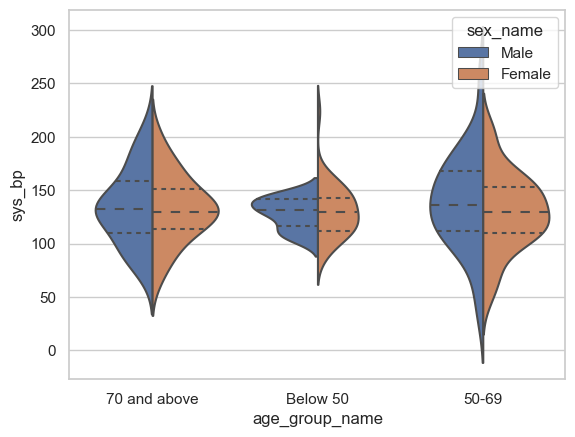

In [23]:
#Violinplot for females vs males blood pressures with respect to each age grp
patient_data = pd.read_sql_query("""SELECT ag.age_group_id,age_group_name,s.sex_id ,sex_name,sys_bp FROM patients p 
JOIN patient_visits pv 
ON p.patient_id = pv.patient_id  
JOIN sexes s
ON s.sex_id = p.sex_id 
JOIN age_groups ag
ON ag.age_group_id = p.age_group_id """, conn)
sns.violinplot(data=patient_data, x='age_group_name', y='sys_bp', hue='sex_name',  inner='quartile', split=True)

Males generally have a higher Sys BP medians compared to females, with more observable differences between the genders in the 50-69 age group. To further study if this difference is significant between females and males in this group, hypothesis testing can be done. (First a normality test using sharpiro-wilk. If the distributions are normal, a parametric t-test can be done. Else (not normal distribution), a Mann-Whitney U test can be used to check for significance.

<AxesSubplot:xlabel='survive', ylabel='count'>

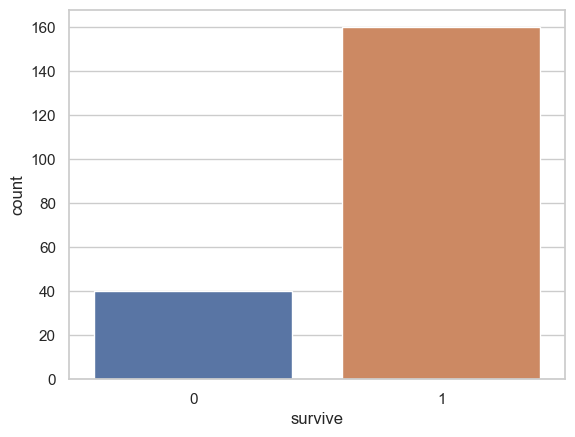

In [24]:
#Check for class balance
survive_df = pd.read_sql_query("SELECT survive FROM patient_visits", conn)
sns.countplot(x=survive_df['survive'])

There is a class imbalance. The minority class (survive=0) only has 40 samples while majority class (survive=1) has 160 samples. Thus, resampling needs to be done to oversample the minority class or undersample the majority class. As undersampling of majority class reduces the model accuracies since it causes loss of information (and led to poor results when tried), oversampling of minority class was done as shown in the next section below.

# Machine Learning

In [25]:
#get all predictors & response vars first
all_data = pd.read_sql_query("""SELECT * FROM patients p 
JOIN patient_visits pv 
ON p.patient_id = pv.patient_id  
JOIN sexes s
ON s.sex_id = p.sex_id 
JOIN age_groups ag
ON ag.age_group_id = p.age_group_id """, conn)

conn.close()

merged_all_df = all_data.T.drop_duplicates().T
merged_all_df.drop(['age','sex_name','patient_id','age_group_name'], axis=1,inplace=True)
merged_all_df.head(5) 

,age_group_id,sex_id,survive,infection,sys_bp,pulse,emergency
0,3,1,0,1,80,96,1
1,1,1,1,1,142,88,1
2,2,0,1,0,112,80,1
3,3,0,1,0,100,70,0
4,3,1,0,1,128,90,1


## Resampling Response Variable ("Survive")

In [26]:
df_majority = merged_all_df[merged_all_df.survive==1]
df_minority = merged_all_df[merged_all_df.survive==0]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=50) # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Check class distribution after upsampling
print(df_upsampled.survive.value_counts())

1    160
0    160
Name: survive, dtype: int64


<AxesSubplot:xlabel='survive', ylabel='count'>

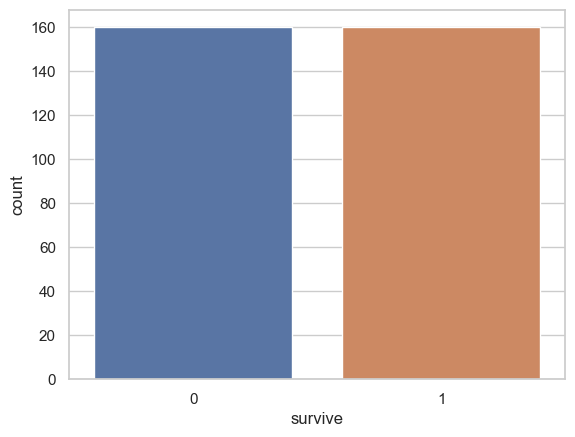

In [27]:
sns.countplot(x=df_upsampled["survive"])

## Train-Test split

In [28]:
# Extract Response and Predictors
y = pd.DataFrame(df_upsampled["survive"].astype(int))
X = pd.DataFrame(df_upsampled[['age_group_id', 'sex_id', 'infection', 'sys_bp', 'pulse','emergency']])

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

# Check the sample sizes
print("Train Set :", y_train.shape, X_train.shape)
print("Test Set  :", y_test.shape, X_test.shape)

Train Set : (240, 1) (240, 6)
Test Set  : (80, 1) (80, 6)


## Random Forest 

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.9333333333333333

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.925



C:\Users\Kirubha\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


<AxesSubplot:>

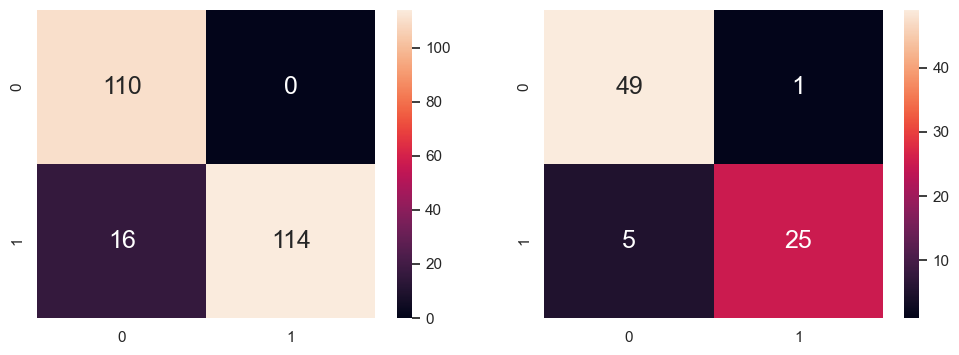

In [29]:
rforest = RandomForestClassifier(n_estimators = 100, max_depth = 6)  
rforest.fit(X_train, y_train)                         

y_train_pred_rf = rforest.predict(X_train)
y_test_pred_rf = rforest.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", rforest.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", rforest.score(X_test, y_test))
print()
rfscore = rforest.score(X_test, y_test)

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(confusion_matrix(y_train, y_train_pred_rf),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sns.heatmap(confusion_matrix(y_test, y_test_pred_rf), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

In [30]:
## Calculating feature importance
feature_importances = pd.DataFrame(rforest.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending = False)
print(feature_importances)

              importance
sys_bp          0.344232
pulse           0.266041
emergency       0.164378
age_group_id    0.140881
infection       0.045389
sex_id          0.039078


## Decision Tree

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.9166666666666666

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.85



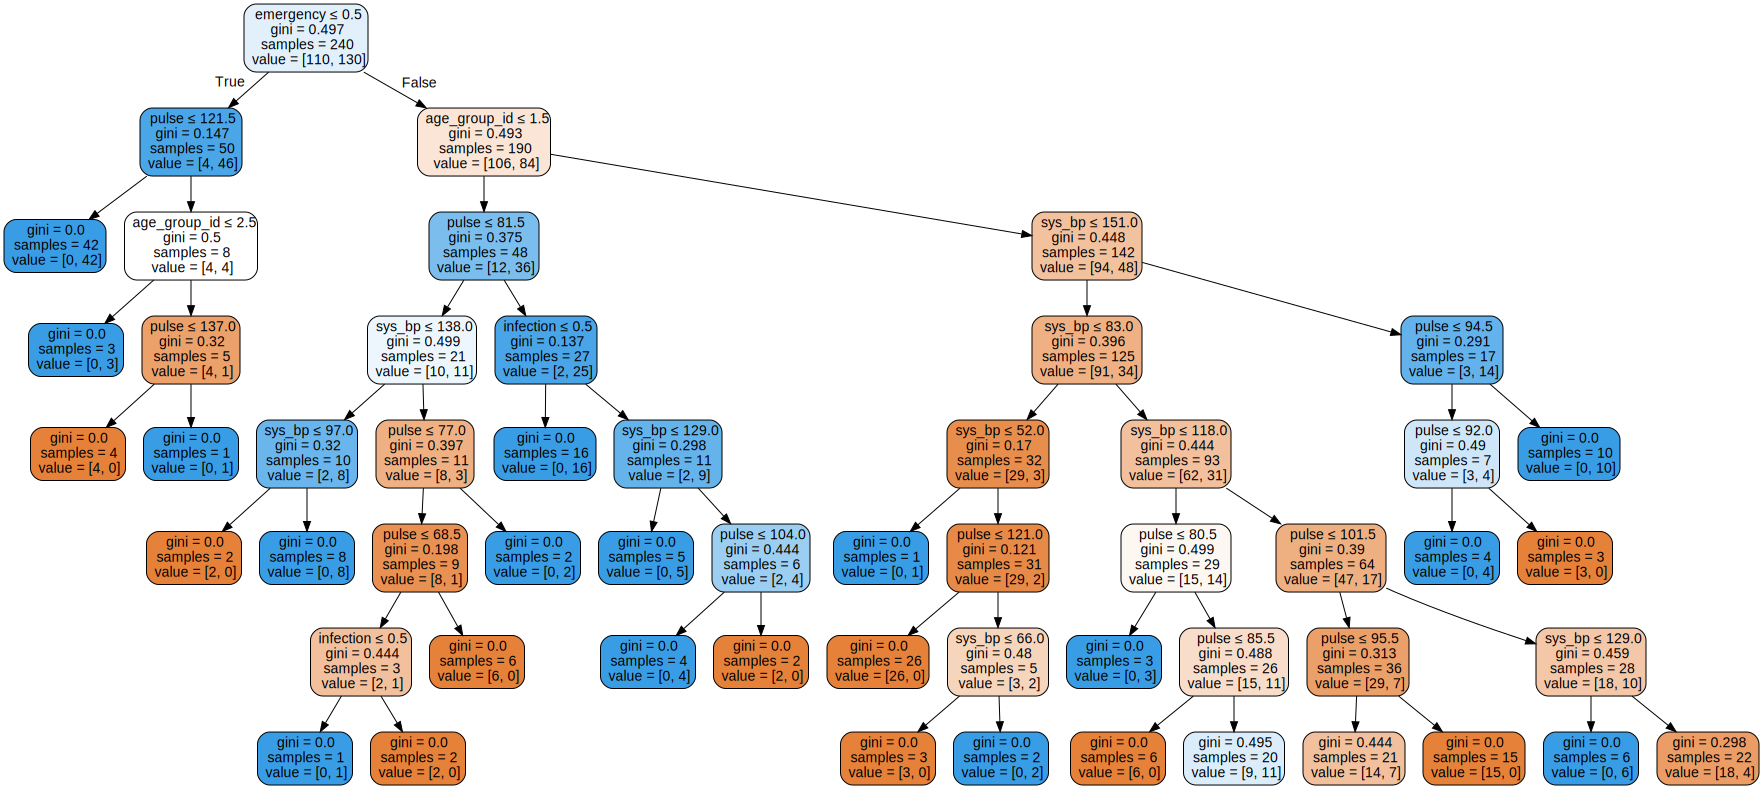

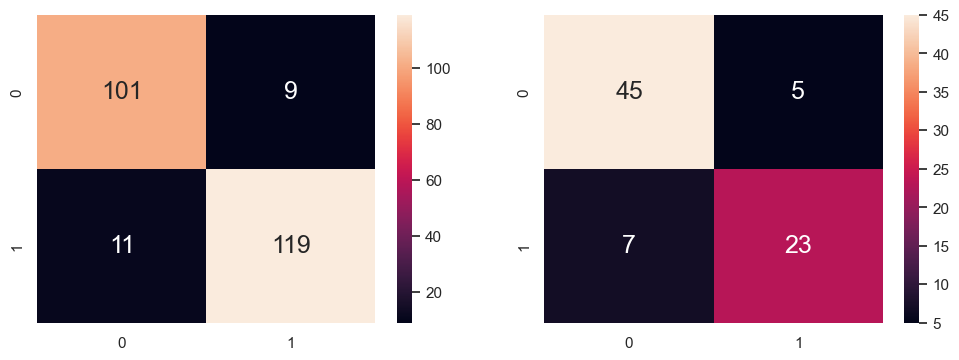

In [31]:
dectree = DecisionTreeClassifier(max_depth = 7)  
dectree.fit(X_train, y_train)                  

y_train_pred_dt = dectree.predict(X_train)
y_test_pred_dt = dectree.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(X_test, y_test))
print()
decscore=dectree.score(X_test, y_test)

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(confusion_matrix(y_train, y_train_pred_dt),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sns.heatmap(confusion_matrix(y_test, y_test_pred_dt), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

# Plot the Decision Tree
treedot = export_graphviz(dectree,                                      # the model
                          feature_names = X_train.columns,              # the features 
                          out_file = None,                              # output file
                          filled = True,                                # node colors
                          rounded = True,                               # make pretty
                          special_characters = True)                    # postscript

graphviz.Source(treedot)

## Logistic Regression

In [36]:
#Search for best params using grid search function

lr = LogisticRegression()
param_grid = {'penalty': ['l1','l2','elasticnet',None],'C': [0.01, 0.1, 1]}
grid_search = GridSearchCV(lr, param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(best_params) #{'C': 1, 'penalty': 'l2'} -- all default values

C:\Users\Kirubha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Kirubha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Kirubha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Kirubha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

{'C': 1, 'penalty': 'l2'}


C:\Users\Kirubha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Kirubha\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
C:\Users\Kirubha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sampl

C:\Users\Kirubha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Kirubha\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.7458333333333333

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.6125



<AxesSubplot:>

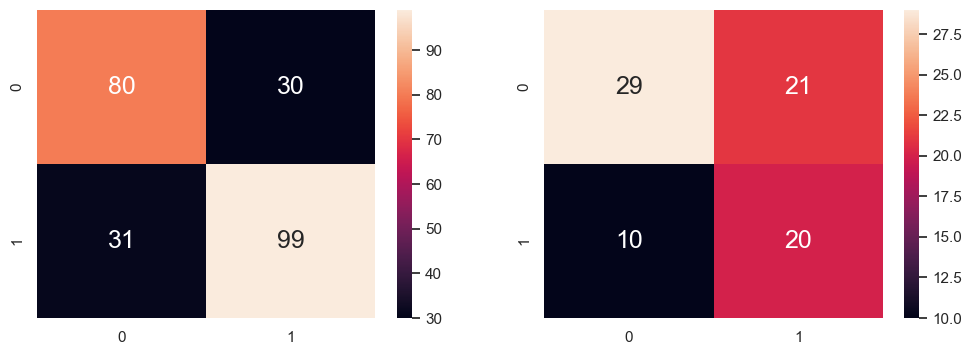

In [37]:
lr = LogisticRegression()
lr.fit(X_train, y_train.values)

y_train_pred_lr = lr.predict(X_train)
y_test_pred_lr = lr.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", lr.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", lr.score(X_test, y_test))
print()

lrscore = lr.score(X_test, y_test)

#Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(confusion_matrix(y_train, y_train_pred_lr),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sns.heatmap(confusion_matrix(y_test, y_test_pred_lr), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

## Performance Comparison

In [38]:
lr_acc = accuracy_score(y_test, y_test_pred_lr)
dt_acc = accuracy_score(y_test, y_test_pred_dt)
rf_acc = accuracy_score(y_test, y_test_pred_rf)

lr_prec = precision_score(y_test, y_test_pred_lr)
dt_prec = precision_score(y_test, y_test_pred_dt)
rf_prec = precision_score(y_test, y_test_pred_rf)

lr_recall = recall_score(y_test, y_test_pred_lr)
dt_recall = recall_score(y_test, y_test_pred_dt)
rf_recall = recall_score(y_test, y_test_pred_rf)

lr_f1 = f1_score(y_test, y_test_pred_lr)
dt_f1 = f1_score(y_test, y_test_pred_dt)
rf_f1 = f1_score(y_test, y_test_pred_rf)

accuracies = [dt_acc,rf_acc,lr_acc]
precisions = [dt_prec,rf_prec,lr_prec]
recalls = [dt_recall,rf_recall,lr_recall]
f1_scores = [dt_f1,rf_f1,lr_f1]
models = ['Decision Tree','Random Forest','Logistic Regression']

print('*'*100)
print('Model Summary:\n')
print('*'*100)
for i in range(len(models)):
    print(models[i]+':')
    print("Accuracy:", accuracies[i], "Precision:", precisions[i], "Recall:", recalls[i], "F1-score:", f1_scores[i])
    print('\n')
print('*'*100)

****************************************************************************************************
Model Summary:

****************************************************************************************************
Decision Tree:
Accuracy: 0.85 Precision: 0.8214285714285714 Recall: 0.7666666666666667 F1-score: 0.793103448275862


Random Forest:
Accuracy: 0.925 Precision: 0.9615384615384616 Recall: 0.8333333333333334 F1-score: 0.8928571428571429


Logistic Regression:
Accuracy: 0.6125 Precision: 0.4878048780487805 Recall: 0.6666666666666666 F1-score: 0.5633802816901409


****************************************************************************************************


<AxesSubplot:xlabel='Model', ylabel='Score'>

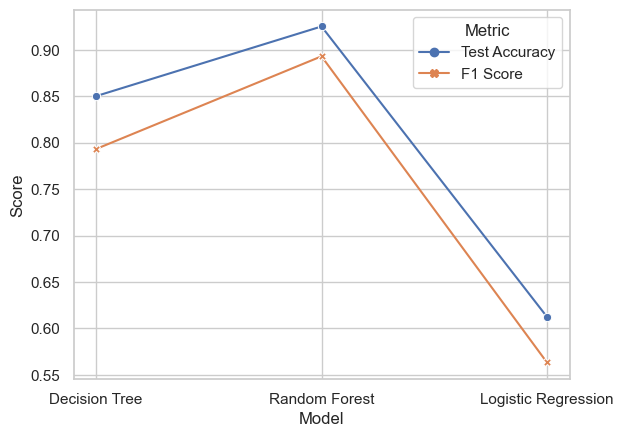

In [39]:
#plot acc + F1 
data = pd.DataFrame(
    {'Model': models,
     'Test Accuracy': accuracies,
     'F1 Score': f1_scores
    })
sns.lineplot(x='Model', y='Score', hue='Metric', markers=True,style="Metric",dashes=False,
             data=pd.melt(data, ['Model'],var_name='Metric', value_name='Score'))

The best model in terms of F1 score and accuracy on test set is Random Forest. Thus, it is the best performing model for this dataset. The most important features are Systolic Blood Pressure and Pulse Rate.